# Immoweb data analysis 

### Importing libraries 

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt



###  Load the Data

In [4]:
data_path = 'data/data_20240313_cleaned.csv'
df_cleaned = pd.read_csv(data_path)

### Initial Data Cleaning with Ordinal and One-Hot Encoding

In [5]:
# Define the function to calculate IQR bounds
def calculate_bounds(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound, Q1, Q3

# Create a dictionary of features to check for outliers
features_to_check = ['price', 'surface_land_sqm', 'total_area_sqm', 'nbr_bedrooms']

# Initialize a dictionary to hold outlier ranges for each feature
outlier_ranges = {}

# Calculate and print the number of outliers for each feature
for feature in features_to_check:
    lower_bound, upper_bound, Q1, Q3 = calculate_bounds(df_cleaned, feature)
    outliers = df_cleaned[(df_cleaned[feature] < lower_bound) | (df_cleaned[feature] > upper_bound)]
    outlier_ranges[feature] = {'lower_bound': lower_bound, 'upper_bound': upper_bound, 'Q1': Q1, 'Q3': Q3}
    print(f"Outliers for {feature}: {len(outliers)}")
    print(f"Range of outliers for {feature}: [{lower_bound}, {upper_bound}]")
    print(f"Interquartile range (IQR) for {feature}: [{Q1}, {Q3}]")
    print()

# Filter out the outliers
filtered_data = df_cleaned[
    (df_cleaned['price'] >= outlier_ranges['price']['lower_bound']) & (df_cleaned['price'] <= outlier_ranges['price']['upper_bound']) &
    (df_cleaned['surface_land_sqm'] >= outlier_ranges['surface_land_sqm']['lower_bound']) & (df_cleaned['surface_land_sqm'] <= outlier_ranges['surface_land_sqm']['upper_bound']) &
    (df_cleaned['total_area_sqm'] >= outlier_ranges['total_area_sqm']['lower_bound']) & (df_cleaned['total_area_sqm'] <= outlier_ranges['total_area_sqm']['upper_bound']) &
    (df_cleaned['nbr_bedrooms'] >= outlier_ranges['nbr_bedrooms']['lower_bound']) & (df_cleaned['nbr_bedrooms'] <= outlier_ranges['nbr_bedrooms']['upper_bound'])
].copy()


# One-hot encoding for categorical variables
categorical_columns = ['property_type', 'heating_type', 'state_building', 'subproperty_type', 
                       'region', 'province', 'locality', 'equipped_kitchen', 'epc']  
df_encoded = pd.get_dummies(filtered_data, columns=categorical_columns)

# After one-hot encoding, handle NaN values for all columns
columns_to_fill = [col for col in df_encoded.columns if col not in ('price', 'id')]
df_encoded[columns_to_fill] = df_encoded[columns_to_fill].fillna(-1)



Outliers for price: 5800
Range of outliers for price: [-77500.0, 774500.0]
Interquartile range (IQR) for price: [242000.0, 455000.0]

Outliers for surface_land_sqm: 3534
Range of outliers for surface_land_sqm: [-832.5, 1787.5]
Interquartile range (IQR) for surface_land_sqm: [150.0, 805.0]

Outliers for total_area_sqm: 3995
Range of outliers for total_area_sqm: [-50.0, 326.0]
Interquartile range (IQR) for total_area_sqm: [91.0, 185.0]

Outliers for nbr_bedrooms: 8376
Range of outliers for nbr_bedrooms: [0.5, 4.5]
Interquartile range (IQR) for nbr_bedrooms: [2.0, 3.0]



### Handle Missing Values for Numeric Columns

In [6]:
numeric_columns = ['construction_year', 'total_area_sqm', 'surface_land_sqm', 'nbr_frontages', 
                   'fl_furnished', 'fl_open_fire', 'fl_terrace', 'terrace_sqm', 'fl_garden', 
                   'garden_sqm', 'fl_swimming_pool', 'fl_floodzone', 'primary_energy_consumption_sqm', 
                   'fl_double_glazing', 'cadastral_income', 'latitude', 'longitude']
df_encoded[numeric_columns] = df_encoded[numeric_columns].fillna(-1)


### Data Preparation for Modeling

In [7]:
X = df_encoded.drop(columns=['price', 'id'])
y = df_encoded['price']


### Split the Data

In [8]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Define Preprocessing and Modeling Pipeline

In [9]:
# Preprocessing for numeric features: scaling
numeric_features = X.select_dtypes(include=['int64', 'float64', 'uint8']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('scaler', StandardScaler())]), numeric_features)
    ],
    remainder='passthrough'  # Include this to keep one-hot encoded columns without scaling
)

# Model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


### Train the Model

In [10]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['zip_code', 'latitude', 'longitude', 'construction_year',
       'total_area_sqm', 'surface_land_sqm', 'nbr_frontages', 'nbr_bedrooms',
       'fl_furnished', 'fl_open_fire', 'fl_terrace', 'terrace_sqm',
       'fl_garden', 'garden_sqm', 'fl_swimming_pool', 'fl_floodzone',
       'primary_energy_consumption_sqm', 'fl_double_glazing',
       'cadastral_income'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

### Evaluate the Model

In [11]:
# Predict on test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')



Mean Squared Error (MSE): 6238827798.40814
Root Mean Squared Error (RMSE): 78986.25069218148
Mean Absolute Error (MAE): 57750.037954638334
R-squared (R2): 0.693795683073851


### Plotting Real vs. Predicted Values

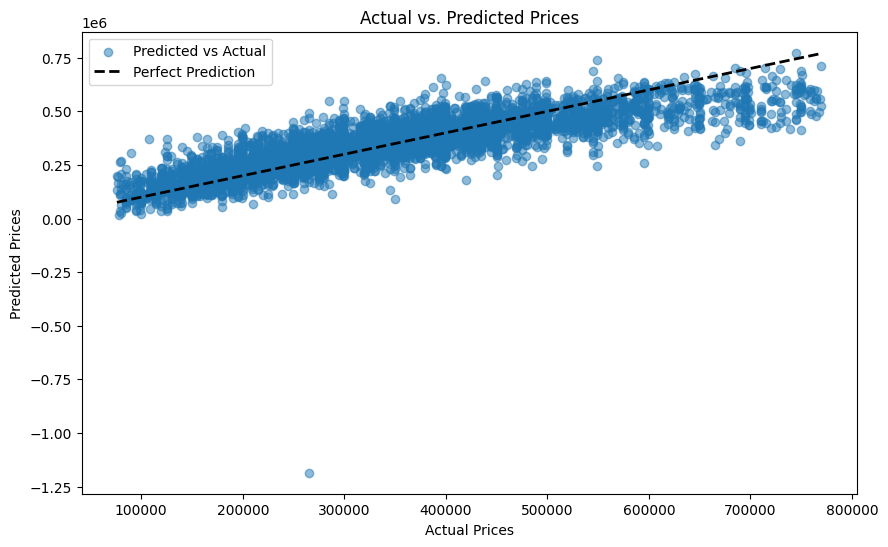

In [16]:
# Assuming y_test are the actual prices and y_pred are the predicted prices from your model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices')
plt.legend(loc='upper left')  # Place the legend in the upper left corner
plt.show()


In [15]:
# Calculate the residuals
residuals = y_test - y_pred

# Find the index of the largest negative residual
outlier_index = residuals.argmin()  # Using argmin since it's a lower outlier

# Retrieve the actual data point corresponding to this outlier
outlier_actual_data = X_test.loc[residuals.idxmin()]
outlier_actual_price = y_test.loc[residuals.idxmin()]
outlier_predicted_price = y_pred[outlier_index]

print("Outlier Details:")
print("----------------")
print(f"Actual Data (features): \n{outlier_actual_data}")
print(f"Actual Price: {outlier_actual_price}")
print(f"Predicted Price: {outlier_predicted_price}")


Outlier Details:
----------------
Actual Data (features): 
zip_code                  8301
latitude             51.330229
longitude             3.237176
construction_year       2023.0
total_area_sqm            51.0
                       ...    
epc_D                    False
epc_E                    False
epc_F                    False
epc_G                    False
epc_MISSING               True
Name: 63488, Length: 124, dtype: object
Actual Price: 108000
Predicted Price: 369551.25


In [17]:
# Predict on the entire dataset
y_pred_entire = model.predict(pd.concat([X_train, X_test]))
y_entire = pd.concat([y_train, y_test])

# Calculate metrics for the entire dataset
mse_entire = mean_squared_error(y_entire, y_pred_entire)
rmse_entire = np.sqrt(mse_entire)
mae_entire = mean_absolute_error(y_entire, y_pred_entire)
r2_entire = r2_score(y_entire, y_pred_entire)

print(f'Mean Squared Error (MSE) on entire dataset: {mse_entire}')
print(f'Root Mean Squared Error (RMSE) on entire dataset: {rmse_entire}')
print(f'Mean Absolute Error (MAE) on entire dataset: {mae_entire}')
print(f'R-squared (R2) on entire dataset: {r2_entire}')


Mean Squared Error (MSE) on entire dataset: 5837869651.002441
Root Mean Squared Error (RMSE) on entire dataset: 76405.95298144275
Mean Absolute Error (MAE) on entire dataset: 57263.60454043892
R-squared (R2) on entire dataset: 0.7141450161724343


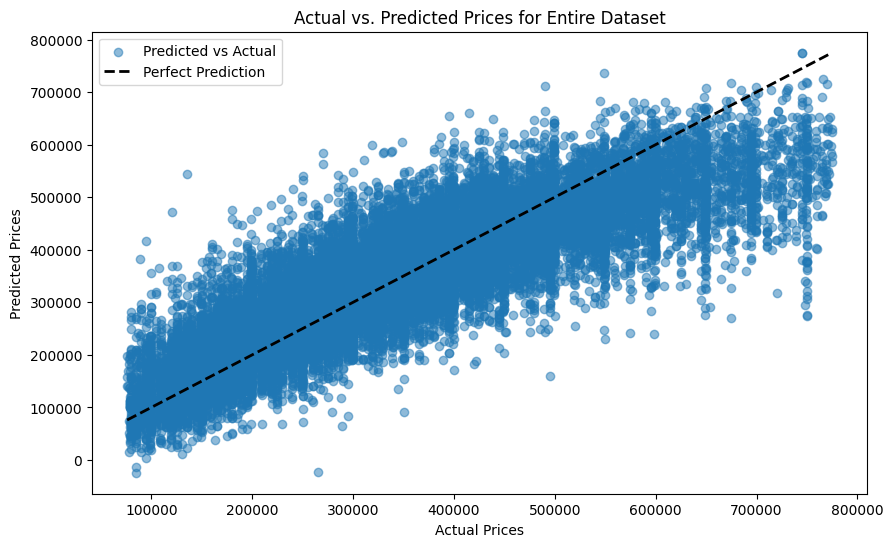

In [19]:
# Combine the training and test sets
X_combined = pd.concat([X_train, X_test])
y_combined = pd.concat([y_train, y_test])

# Predict on the combined dataset
y_pred_combined = model.predict(X_combined)

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_combined, y_pred_combined, alpha=0.5, label='Predicted vs Actual')
plt.plot([y_combined.min(), y_combined.max()], [y_combined.min(), y_combined.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices for Entire Dataset')
plt.legend(loc='upper left')  # Place the legend in the upper left corner
plt.show()
